In [1]:
# Reading the text file
with open('data/goblet_book.txt', 'r') as file:
    book_data = file.read()

# Getting unique characters
book_chars = sorted(set(book_data))
K = len(book_chars)  # dimensionality of the output (input) vector of your RNN

# Initializing maps

char_to_ind = {char: ind for ind, char in enumerate(book_chars)}
ind_to_char = {ind: char for ind, char in enumerate(book_chars)}



# Now, char_to_ind and ind_to_char can be used for converting between characters and their corresponding indices


# test using text "hello"
hello = 'hello'
hello_ind = [char_to_ind[char] for char in hello]
print(hello_ind)
print([ind_to_char[ind] for ind in hello_ind])




[58, 55, 62, 62, 65]
['h', 'e', 'l', 'l', 'o']


In [2]:

import numpy as np

# Set hyper-parameters
m = 100  # dimensionality of the hidden state
eta = 0.1  # learning rate
seq_length = 25  # length of the input sequences

# Initialize the RNN's parameters


class RNN:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.1, seq_length=25, sigma=0.01):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.seq_length = seq_length
        

        # Initialize weights and biases
        self.W = np.random.randn(hidden_size, hidden_size) / np.sqrt(hidden_size)  # weights for hidden states
        self.U = np.random.randn(hidden_size, input_size) / np.sqrt(input_size)  # weights for inputs
        self.b = np.zeros((hidden_size, 1))                        # bias for hidden states
        self.V = np.random.randn(output_size, hidden_size) / np.sqrt(hidden_size) # weights for output
        self.c = np.zeros((output_size, 1))                        # bias for output


# Initialize the RNN
rnn = RNN(K, m, K, learning_rate=eta, seq_length=seq_length)


In [3]:

def synthesize(rnn, h0, x0, n):
    h = h0
    x = x0
    Y = np.zeros((rnn.output_size, n))
    print(h.shape)

    for t in range(n):
        # Compute the hidden state
        a = np.dot(rnn.W, h.ravel()) + np.dot(rnn.U, x.ravel()) + rnn.b.ravel()
        h = np.tanh(a)

        # Compute the output
        o = np.dot(rnn.V, h) + rnn.c.ravel()
        p = np.exp(o) / np.sum(np.exp(o))  # normalize to get probabilities

        # Sample a character index from the probability distribution
        ix = np.random.choice(range(rnn.output_size), p=p.ravel())

        # Update the input for the next time step
        x = np.zeros((rnn.input_size, 1))
        x[ix] = 1

        # Store the one-hot representation of the sampled character
        Y[:, t] = x.ravel()


    return Y

def one_hot_seq_to_char_seq(one_hot_seq, ind_to_char):
    N = one_hot_seq.shape[1]
    char_seq = ''.join([ind_to_char[np.argmax(one_hot_seq[:, i])] for i in range(N)])
    return char_seq

In [4]:

h0 = np.zeros((m, 1))
x0 = np.zeros((K, 1))
n = 100

Y = synthesize(rnn, h0, x0, n)
#text = ''.join(ind_to_char[np.argmax(Y[:, i])] for i in range(n))
text = one_hot_seq_to_char_seq(Y, ind_to_char)
print(text)

(100, 1)
E•PPROOzwE9R?pitZsxt-mYQEsfVZ("ongPD1/!gr 2KKF'"-}pqFv?/2_ WQK9a7g}D
d(cjvf,,lRkZ4gGtF"QEP,!O.hwa•U1


In [5]:

import numpy as np
import copy

def compute_grad_num(X, Y, f, rnn, h):
    n = np.prod(getattr(rnn, f).shape)
    grad = np.zeros(getattr(rnn, f).shape)
    hprev = np.zeros((rnn.W.shape[0], 1))
    for i in range(n):
        RNN_try = copy.deepcopy(rnn)
        param = getattr(RNN_try, f).flatten()
        param[i] -= h
        setattr(RNN_try, f, param.reshape(getattr(rnn, f).shape))
        l1, _ = forward_backward_pass(RNN_try, X, Y, hprev)
        param[i] += 2*h
        setattr(RNN_try, f, param.reshape(getattr(rnn, f).shape))
        l2,_ = forward_backward_pass(RNN_try, X, Y, hprev)
        grad.flat[i] = (l2-l1) / (2*h)
    return grad

def compute_grads_num(X, Y, rnn, h):
    num_grads = {}
    for f in ['W', 'U', 'b', 'V', 'c']:
        print('Computing numerical gradient for')
        print('Field name: ', f)
        num_grads[f] = compute_grad_num(X, Y, f, rnn, h)
       
    return num_grads




def forward_backward_pass(rnn, X_chars, Y_chars, h0):

    # Initialize the hidden states and outputs
    h = np.zeros((rnn.b.shape[0], len(X_chars) + 1))
    h[:, 0] = h0.ravel()
    o = np.zeros((len(rnn.c), len(X_chars)))
    p = np.zeros((len(rnn.c), len(X_chars)))


    # Forward pass
    for t in range(X_chars.shape[1]):


        #a = np.dot(rnn.W, h.ravel()) + np.dot(rnn.U, x.ravel()) + rnn.b.ravel()
        #h = np.tanh(a)

        a1 = np.dot(rnn.W, h[:, t].ravel())
        a2 = np.dot(rnn.U, X_chars[:, t]) 
        a = a1 + a2 + rnn.b.ravel()
        h[:, t + 1] = np.tanh(a).ravel()
        o[:, t] = (np.dot(rnn.V, h[:, t + 1]) + rnn.c.ravel())

        p[:, t] = np.exp(o[:, t]) / np.sum(np.exp(o[:, t]))  # normalize to get probabilities

    loss = -np.sum(Y_chars * np.log(p[:, :Y_chars.shape[1]]))  # cross-entropy loss

    # Initialize the gradients
    grads = {
        'U': np.zeros_like(rnn.U),
        'W': np.zeros_like(rnn.W),
        'V': np.zeros_like(rnn.V),
        'b': np.zeros_like(rnn.b),
        'c': np.zeros_like(rnn.c)
    }

    # Backward pass
    dh_next = np.zeros_like(h[:, 0])
    for t in reversed(range(Y_chars.shape[1])):
        do = p[:, t] - Y_chars[:, t]
        grads['V'] += np.outer(do, h[:, t + 1])
        grads['c'] += do.reshape(rnn.c.shape)

        dh = np.dot(rnn.V.T, do) + dh_next
        da = (1 - h[:, t + 1]**2) * dh

        grads['U'] += np.outer(da, X_chars[:, t])
        grads['W'] += np.outer(da, h[:, t])
        grads['b'] += da.reshape(rnn.b.shape)

        dh_next = np.dot(rnn.W.T, da)


    # Clip the gradients to avoid exploding gradient problem
    for grad in grads.values():
        np.clip(grad, -5, 5, out=grad)

    return loss, grads

In [6]:
def relative_error(grad_num, grad_analytic):
    rel_errors = np.abs(grad_num - grad_analytic) / np.maximum(1e-6, np.abs(grad_num) + np.abs(grad_analytic))
    return np.mean(rel_errors)

X_chars = book_data[0:seq_length]
Y_chars = book_data[1:seq_length + 1]


def one_hot_encode(sequence, vocab_size):
    # Create an array of zeros with length of the sequence and vocab size
    one_hot = np.zeros((vocab_size, len(sequence)))

    # For each character in the sequence, change the corresponding index in the array to 1
    for i, char in enumerate(sequence):
        one_hot[char_to_ind[char], i] = 1.0  

    return one_hot

In [7]:

# One-hot encode the input sequences
X_chars_encoded = one_hot_encode(X_chars, K)
Y_chars_encoded = one_hot_encode(Y_chars, K)

#loss, (h, o, p) = forward_pass(rnn, X_chars_encoded, Y_chars_encoded, h0)
#grads = backward_pass(rnn, X_chars_encoded, Y_chars_encoded, h, p)


h = 1e-5

# Compute numerical gradients
num_grads = compute_grads_num(X_chars_encoded, Y_chars_encoded, rnn, h)

# Compute analytical gradients
_, ana_grads = forward_backward_pass(rnn, X_chars_encoded, Y_chars_encoded, h0)


Computing numerical gradient for
Field name:  W
Computing numerical gradient for
Field name:  U
Computing numerical gradient for
Field name:  b
Computing numerical gradient for
Field name:  V
Computing numerical gradient for
Field name:  c


In [8]:

# Compare gradients
for param in ['W', 'U', 'b', 'V', 'c']:
    rel_error = relative_error(num_grads[param], ana_grads[param])
    print(f'Relative Error for {param}: {rel_error}')


Relative Error for W: 8.138271008732453e-09
Relative Error for U: 5.517090040660222e-10
Relative Error for b: 1.5156957352092124e-09
Relative Error for V: 1.0469489263380888e-07
Relative Error for c: 6.507072807927327e-10


In [9]:

loss, grads = forward_backward_pass(rnn, X_chars_encoded, Y_chars_encoded, h0)


#loss, grads = forward_backward_pass(rnn, X_chars_encoded, Y_chars_encoded, h0)
for param, grad in grads.items():
    param_value = getattr(rnn, param)
    param_value -= eta * grad
    setattr(rnn, param, param_value)

print(loss)

110.09567154007051


In [10]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy

def train_rnn(rnn, book_data, char_to_ind, ind_to_char, n_epochs):
    K = rnn.output_size
    seq_length = rnn.seq_length

    iter_per_epoch = len(book_data) // seq_length
    updates = n_epochs * iter_per_epoch
    smooth_loss = -np.log(1.0 / K) * seq_length  # loss at iteration 0
    hprev = np.zeros((rnn.hidden_size, 1))
    ada_params = {k: np.zeros_like(getattr(rnn, k)) for k in ['U', 'W', 'V', 'b', 'c']}

    smooth_loss_list = []
    best_loss = np.inf

    e= 0
    for update in tqdm(range(updates)):
        if e == 0 or e + seq_length + 1 > len(book_data):
            e = 1
            hprev = np.zeros((rnn.hidden_size, 1))  # reset RNN memory

        X_chars = book_data[e:e + seq_length]
        Y_chars = book_data[e + 1:e + seq_length + 1]

        X = one_hot_encode(X_chars, K)
        Y = one_hot_encode(Y_chars, K)

        loss, grads = forward_backward_pass(rnn, X, Y, hprev)

        # Update the parameters using Adagrad
        for param, grad in grads.items():
            param_value = getattr(rnn, param)
            ada_params[param] += grad**2
            param_value -= eta * grad / np.sqrt(ada_params[param] + 1e-8)
            setattr(rnn, param, param_value)

        smooth_loss = smooth_loss * 0.999 + loss * 0.001
        smooth_loss_list.append(smooth_loss)

        if smooth_loss < best_loss:
            rnn_best = copy.deepcopy(rnn)
            best_loss = smooth_loss

        if update % 10000 == 0:
            print("Smooth loss at step {}: {}".format(update, smooth_loss))
            Y_synthesized = synthesize(rnn, hprev, X[:, :1], 200)
            synthesized_seq = one_hot_seq_to_char_seq(Y_synthesized, ind_to_char)
            print("Update step {}: Synthesized text:\n".format(update), synthesized_seq)

        if update % 100000 == 0:
            Y_synthesized = synthesize(rnn, hprev, X[:, :1], 200)
            synthesized_seq = one_hot_seq_to_char_seq(Y_synthesized, ind_to_char)
            print("Synthesized text:\n", synthesized_seq)

    

        e += seq_length
    print(25*"_")

    Y_synthesized = synthesize(rnn_best, hprev, X[:, :1], 1000)
    synthesized_seq = one_hot_seq_to_char_seq(Y_synthesized, ind_to_char)
    print("Synthesized text:\n", synthesized_seq)
    plt.plot(smooth_loss_list)
    plt.title("Smooth loss over time")
    plt.xlabel("Iteration")
    plt.ylabel("Smooth loss")
    plt.show()
        


  0%|          | 43/310107 [00:00<23:22, 221.10it/s]

Smooth loss at step 0: 109.54162262283377
(100, 1)
Update step 0: Synthesized text:
 DGrGNaNR(INGNDNE 3NyNGNBNINBNDNt7GND ENGHEL'NIHGgRODfGNdNGJ'NnYG DNGOpN0LRNDNAqDLENGL'NG,ENRPDNA BN
 DNAN'L•HEOSJR RNGNRTANRL	PDN4NELDNQNG A?G^RNGNENDNGODNG 'NGNGTILDNBWANdNBNB AHoNR-GHZPANBLANBcG GNB
(100, 1)
Synthesized text:
 9GHnNDNB pORNAHAtD GNd !O	 mNDPBNMNp GNGOG!4Nu_RNt;B6GPRNDNCNBNG AVYNG DNGNEjBoGNz IN}NRNGNANRNMOXNDNE G3BNENmNR_GNDNA
RLBNKNRFBN2NBNDLGNGNANGNGNGHRyDNGNDWR GNBN; 9NGNdNGgRNGNDNGHDNBN'NGtG } G RXENMVG


  3%|▎         | 10031/310107 [00:38<18:44, 266.75it/s]

Smooth loss at step 10000: 53.92121808921535
(100, 1)
Update step 10000: Synthesized text:
 ," oulling,"
"renmouggs -". s warctere to paht nevis-go-h .  hayr mho thon and alley ChEy ha peatmis in at to cithtor in "Drading, Ur. Wa? mave plat Doa dimpe'n she ronnly abawly.  Tarrarechly the ran


  6%|▋         | 20035/310107 [01:19<17:24, 277.63it/s]

Smooth loss at step 20000: 50.73137049014566
(100, 1)
Update step 20000: Synthesized text:
  that got tolderidy the "I's iet exuing a diddy, warr)es helk to dngitge firthen't filln's wiicht he to the - se tow diggtentt of -""
Mr. -" har to his hit?" said heered in soe bren to thanled tht his


 10%|▉         | 30037/310107 [01:55<15:57, 292.35it/s]

Smooth loss at step 30000: 49.40431832563708
(100, 1)
Update step 30000: Synthesized text:
 r afl upransper. Harry, harren warrs.
"Ye'ghune'rrcaunclar; nto wands wheee walesly harrseger.  he she drortoreh "himed thackerore rowe finclr..  Hermed flew largw.  "He ferede griin feeft. . . . in l


 13%|█▎        | 40052/310107 [02:28<15:47, 285.16it/s]

Smooth loss at step 40000: 48.06094792504058
(100, 1)
Update step 40000: Synthesized text:
 e poldemort hadde ungail.  Vo giten Vimpy ... breail noteafred watce. Tecroud oner the could and thending and the steyted the neardesting orederund umoat ato thide made thond cerionn you what les he r


 16%|█▌        | 50035/310107 [03:03<16:10, 268.03it/s]

Smooth loss at step 50000: 49.08900549700873
(100, 1)
Update step 50000: Synthesized text:
 Hermioned out up themed Antilee Opad a death foreisning thats and, tad not uby woukngoonnds Trithey favedy the reckldeen tuatlt the hastlick soreeverss, gould said Horrudle eakos as they por gow Croup


 19%|█▉        | 60049/310107 [03:39<13:54, 299.80it/s]

Smooth loss at step 60000: 47.64147259206661
(100, 1)
Update step 60000: Synthesized text:
 g the tart Gobet Petpred. .  "Ah Harry yen leamient the Dolfooss. Theme from Harry and Glyeming dee, He gre jost theyesser, stom owe hat Resle't'smen sharram stole.
"
Siffindch. Ameyt, Ron their co's,


 23%|██▎       | 70038/310107 [04:14<13:01, 307.12it/s]

Smooth loss at step 70000: 47.401212130764726
(100, 1)
Update step 70000: Synthesized text:
 e owe dingtre?  Of you clold Profe as and would quitee!" I'm.," said Row exion was indoried they waid Horm cal glide had now of hoight?
"OPE Rog wal hould wantitt, and off harh.. as in a doings, I whi


 26%|██▌       | 80033/310107 [04:47<12:41, 302.21it/s]

Smooth loss at step 80000: 45.70499525200404
(100, 1)
Update step 80000: Synthesized text:
 leafor be, Tenisen and of icned."
He been was wamand twall to digutione wanched, or?"
Karkarieg."  said Mrsansor of the gable him, been tringeen, Con tho as schis tow ap had and had taisnoned not of l


 29%|██▉       | 90035/310107 [05:20<12:18, 298.12it/s]

Smooth loss at step 90000: 46.30931180838627
(100, 1)
Update step 90000: Synthesized text:
 ast insaing thoughed at up the Sine we kith that at Harry been uh him.  nestething Dursl's had will poings, thad looking wousneb bave,, hed he sendore. "Wellle full on deadleesor lefle. "At he whering


 32%|███▏      | 100049/310107 [05:53<11:43, 298.64it/s]

Smooth loss at step 100000: 47.17415242111384
(100, 1)
Update step 100000: Synthesized text:
 the Harry the with stupl of at faioned ridy roned time on saids comp at to and meytw bance ecyou, chaged steace le and undiced ficthed Mr. Beang it exe it.  "vildoy beleale, Cro know owe."
"Cemctsing 
(100, 1)
Synthesized text:
 youring tot Fred ho's whe wis was in eyet enet eecatt Dumbens tolled to the stinks one at that mofrew in wallemont, stand it caseetore, og awoug, who stided and it letrer we be and of thion.  Weaulkin


 35%|███▌      | 110039/310107 [06:30<12:06, 275.48it/s]

Smooth loss at step 110000: 45.38886421934309
(100, 1)
Update step 110000: Synthesized text:
 oothight's the cizedorcts win tor, wile tile his hat of the bokes.  An' doldel the who vor off scop peving.  He anvery.
"Lefent.  And timp lasply, !"
"Weat Hermiove MAGidool.  Harr offed.  He would th


 39%|███▊      | 120031/310107 [07:04<11:03, 286.38it/s]

Smooth loss at step 120000: 45.83563479400338
(100, 1)
Update step 120000: Synthesized text:
 was rid's in might iftary," said Kefchower tlosing felly was oact fill ragin; like and tulk Starge. Then conderath. Moldore vurce, have them acered daut upla, - whens hers frown, Ron who witcone, that


 42%|████▏     | 130051/310107 [07:37<09:42, 309.36it/s]

Smooth loss at step 130000: 44.43434533159961
(100, 1)
Update step 130000: Synthesized text:
 s speet weet sawas.  When stick had ute had ov."
Snow any into finsorthered my it sherter at he was feem eds, down it it.  by a Clooker op, Werrlf knew pose fees demernd ma up the cas beem haw, patt d


 45%|████▌     | 140046/310107 [08:12<09:27, 299.84it/s]

Smooth loss at step 140000: 47.59829691399473
(100, 1)
Update step 140000: Synthesized text:
 d allong, the eyes thoughte his loagly somat a a nles and that the Buggared pithition his pistouted of it, his wanditn't to de yer bedreystents magabled cantt Mood and then imletered and and the bus g


 48%|████▊     | 150048/310107 [08:50<10:28, 254.87it/s]

Smooth loss at step 150000: 44.88591927045261
(100, 1)
Update step 150000: Synthesized text:
 e, to the being almeassliought, antwert.
	Mr.  Bildoned cotthat?"
"I said in then to toon are you's ween nopens of lowed."
Of chers with chorke looken beore got adroddeds spell tee Vroze and it.
Ot?" 


 52%|█████▏    | 160034/310107 [09:24<08:21, 299.49it/s]

Smooth loss at step 160000: 45.402442798351224
(100, 1)
Update step 160000: Synthesized text:
  mownatk so gof rast and is a weat Hagry froning is shese soundingway by the leidlixpotking have, quatt out -"
"Fnery?"  Harry.
"So having of the craand of the rosing. . . Batte, loy!"  Harry, boty ka


 55%|█████▍    | 170051/310107 [10:02<07:57, 293.58it/s]

Smooth loss at step 170000: 44.508832039813704
(100, 1)
Update step 170000: Synthesized text:
 ust fromble cut Dust fire my gore about ainylark in the if moge chund up the carmed styeis just.  But theves of see from she harmion, and a had shaf hed shousest arrapplert whre of kherrlet rone unen!


 58%|█████▊    | 180028/310107 [10:35<07:22, 294.08it/s]

Smooth loss at step 180000: 45.144748713279384
(100, 1)
Update step 180000: Synthesized text:
 ry throght were Vullors was to den't befory five Dedsmuring conteringaged of scome socly.  Vnaky,  tread alxtow, botwing?"
 Flive hayining.  "Ok Harry, Proit ow, suid Dudfil I about to then, currsany 


 61%|██████▏   | 190039/310107 [11:15<07:32, 265.41it/s]

Smooth loss at step 190000: 45.5724091676325
(100, 1)
Update step 190000: Synthesized text:
 in thair brobace Curey Oneby for bruth to ice, out all at him looking sornain, pistall solvigh sour barily, tows you dgan thind that ell got, at the liaichain intell bedins, Carrioully ind very his ve


 65%|██████▍   | 200032/310107 [11:53<07:17, 251.64it/s]

Smooth loss at step 200000: 44.1669086507996
(100, 1)
Update step 200000: Synthesized text:
 hurriw up I slid, whatte yol.
"Whad. Jarl.
"ARly "noon of attardy, starpay conigh Horking moment down then hea had I caswerting bounder; crow. ," sho teamightlad, just off a contunts wele still - neve
(100, 1)
Synthesized text:
 to been specks.  "Wourse thaloon out end thaist wood plice had got bouss, skile, Ron!"  druggn' bare!"
Dubby apaM!" said thamld doner.
"Whothard, in Harry, sisputed.  "E't heacbood I'm his andoud seam


 68%|██████▊   | 210058/310107 [12:32<05:28, 304.14it/s]

Smooth loss at step 210000: 44.24563793662754
(100, 1)
Update step 210000: Synthesized text:
 se't the his right wasw end now stall spidering he'd eneth around chaUt staring to gilly, and lagg whot'resh hadl seem not could. drearing sery bote putherorele.  Chericksing airy heatht we'le of the 


 71%|███████   | 220044/310107 [13:04<04:57, 302.41it/s]

Smooth loss at step 220000: 43.13774926431527
(100, 1)
Update step 220000: Synthesized text:
 al !"
"Yom you can coined full beist Herred, you exmust.  requids san to comple-lart.  I sortrase is he paive ter sups tly mone, byouse- ther ooned tear stepping and ext of wark I sumore to prieve, "E


 74%|███████▍  | 230045/310107 [13:36<04:20, 307.19it/s]

Smooth loss at step 230000: 43.56144655096934
(100, 1)
Update step 230000: Synthesized text:
 ownsize. Whrotsing will plame offling tonvers it, the squieched of Mr. Weasley thas boxm could wish opGar, they sas onllkinks was him hell defled ackne," said, air looking all wits it of Crous! I'n co


 77%|███████▋  | 240027/310107 [14:12<04:35, 254.21it/s]

Smooth loss at step 240000: 44.229682838560386
(100, 1)
Update step 240000: Synthesized text:
 Harry."
Then, was pand ofing posing and it of it druds.
Ponceandund to He was nothanbuinn a blong.  He was and he skill then?"

"The leeplep.  I tither.   Cedrice, upon theig lettery lain' pecky bly d


 81%|████████  | 250039/310107 [14:48<03:36, 277.49it/s]

Smooth loss at step 250000: 44.80718776516417
(100, 1)
Update step 250000: Synthesized text:
 nce; a of it!"  what it, come chen hornten where on the beement fratur," said Moody"
"What heuppacely where don't hea, scassing Dapf sortaiss; very solly!" "Fox giggar," said Fade and his fees of of t


 84%|████████▍ | 260038/310107 [15:22<03:09, 264.28it/s]

Smooth loss at step 260000: 42.999835271188786
(100, 1)
Update step 260000: Synthesized text:
 ce to skee is their at He his were shouther!
Harry?" samant the naberor.  He worked your must, inta a air his anvey enouchon himsly, broubly undy hance wher, think in thin' and tast affelk hurrom.
"Yo


 87%|████████▋ | 270038/310107 [15:56<02:40, 249.80it/s]

Smooth loss at step 270000: 44.1380351806904
(100, 1)
Update step 270000: Synthesized text:
 hrething over of up.  "I deemore.  The at wead bot anpurs had tups lich staved ourcornully."
 Harry's heltest ppeisting poine course intear out hard appande and seile.  He wasn't can use now, scapped 


 90%|█████████ | 280030/310107 [16:30<01:39, 302.15it/s]

Smooth loss at step 280000: 44.890404737958185
(100, 1)
Update step 280000: Synthesized text:
 Dast room asteching clued You't the and the they firelt?" said Harry and caulded, somaid mered rigof!" Moody.
"I was that all wamw Garay the to preving had ir, Hermiupenting whits and Mrsas pailied lo


 94%|█████████▎| 290034/310107 [17:04<01:05, 308.14it/s]

Smooth loss at step 290000: 43.33124724893971
(100, 1)
Update step 290000: Synthesized text:
 the with Peaty a starrad lainay, her potworsted go his lidn't hol twertilaslagly," has wordiny one to that them lausius; Hermione soidend.
"Youd down it at Harry.  "I her with Harry?"  Rons ap withoon


 97%|█████████▋| 300042/310107 [17:36<00:34, 293.33it/s]

Smooth loss at step 300000: 42.20151525164696
(100, 1)
Update step 300000: Synthesized text:
 ot got anyonching," Hagry jump!" Harry por so clitsid, harrsive to been whent ... him."
"U Krum As. . .

Cg he about blars mor and can turned craid, aw you darn.  "Now me fan he day.
"Whand wast out o
(100, 1)
Synthesized text:
 e he dore brice ofce's the erore trny," said broughothing in the ground wat us. "Er he'd have you, an rake. . . the trew stabbing you?" 'ast oning and pawasull him.
"Singo," he did you're tharmy why w


100%|█████████▉| 310052/310107 [18:13<00:00, 281.22it/s]

Smooth loss at step 310000: 42.1702634181173
(100, 1)
Update step 310000: Synthesized text:
 od on their.  time this ligol - Diggonudn's Trough knyh "Kchilful fhen Worndem deay lake, Moggath Crouched he could Grod the toot tang to ant at the with into the dosbed tonen at I'm ncoping looked an


100%|██████████| 310107/310107 [18:14<00:00, 283.42it/s]


_________________________
(100, 1)
Synthesized text:
 g follesting sulled at on Voldeam of har he was Deebblet cally and Freuchion must gonem.
"I suideet Domention, Volded roem and you boning to then that so re anyion of of of Art a good louse see dask nisting," said Harry face, thind a hyaid Dumbledore Fred he bumo-.
You had he nerctilw at then we said was had joleen toke at Dured Padlerming lodests subbleared wey it of gring sing, hare faing to forned it dished, kiving plightoned tureyn's ained him, which," said Dumbleyor so back.  "Pevicul moingely's tele.
"Domed roo to who golensed ae it wart Dean't opeevey upinged Ste of cabone was he saiting waw quiet to and nught to deened was yeared unon "Er.

Pottaek ip had with hims.
"Any icted the tass wich thremine four, Manam arm.
Harry eace?" "Yeing He said grat, kippas torted be said."
Hormtoul. .  Ah the table will heew.  "He foldawing puand Domest head boine?" said He Trough no Moged in the was leet, has, Awasked in chair sinnore shout

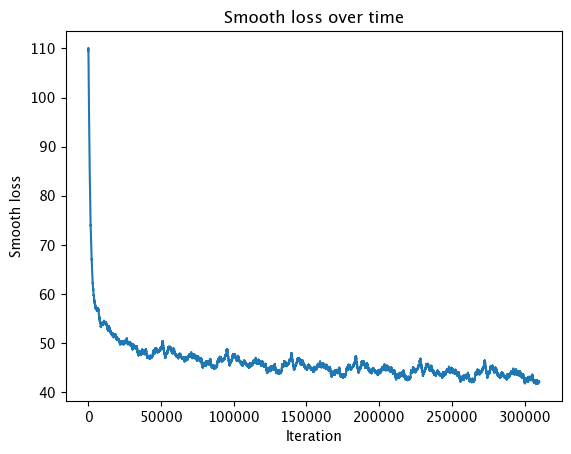

In [11]:
rnn = train_rnn(rnn, book_data, char_to_ind, ind_to_char, n_epochs=7)
